[View in Colaboratory](https://colab.research.google.com/github/Sarkin/nlp2018/blob/master/DNN_HW2.ipynb)

In [1]:
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision
!pip install -q keras 

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
from IPython import display

# Путь джедая

## Введение в PyTorch

Вообще говоря, все приличные люди начинают изучение PyTorch с его внутренностей: всяких Tensor'ов, Variable'ов и прочих autograd'ов.

Обязательно почитайте статью, в которой подробно расписано это всё: [PyTorch — ваш новый фреймворк глубокого обучения (habrahabr)](https://habrahabr.ru/post/334380/).

А мы пока просто пробежимся по главному.

### Тензоры

Тензоры в PyTorch - это как numpy.array. Они есть разных типов, причем типизация строгая:
```python
torch.HalfTensor      # 16 бит, с плавающей точкой
torch.FloatTensor     # 32 бита,  с плавающей точкой
torch.DoubleTensor    # 64 бита, с плавающей точкой

torch.ShortTensor     # 16 бит, целочисленный, знаковый
torch.IntTensor       # 32 бита, целочисленный, знаковый
torch.LongTensor      # 64 бита, целочисленный, знаковый

torch.CharTensor      # 8 бит, целочисленный, знаковый
torch.ByteTensor      # 8 бит, целочисленный, беззнаковый
```

Например, можем создать тензор нужного размера:

In [2]:
x = torch.FloatTensor(3, 4)   # мусор
x.zero_()                     # нули


 0  0  0  0
 0  0  0  0
 0  0  0  0
[torch.FloatTensor of size 3x4]

А можем сделать его из готового array'я:

In [3]:
x = np.arange(8).reshape(2, 4) + 5
y = np.arange(8).reshape(2, 4)
print(x)
print(y)

x = torch.LongTensor(x)
y = torch.LongTensor(y)
print(x)
print(y)

[[ 5  6  7  8]
 [ 9 10 11 12]]
[[0 1 2 3]
 [4 5 6 7]]

  5   6   7   8
  9  10  11  12
[torch.LongTensor of size 2x4]


 0  1  2  3
 4  5  6  7
[torch.LongTensor of size 2x4]



Можем делать стандартные операции:

In [4]:
print(x + y)

print(x * y)

print(x.type(torch.FloatTensor).log())


  5   7   9  11
 13  15  17  19
[torch.LongTensor of size 2x4]


  0   6  14  24
 36  50  66  84
[torch.LongTensor of size 2x4]


 1.6094  1.7918  1.9459  2.0794
 2.1972  2.3026  2.3979  2.4849
[torch.FloatTensor of size 2x4]



### Разминка
Возьмем простую математическую функцию с прикольным графиком:

$$ x(t) = t - 1.5 \cdot cos( 15 t) $$
$$ y(t) = t - 1.5 \cdot sin( 16 t) $$

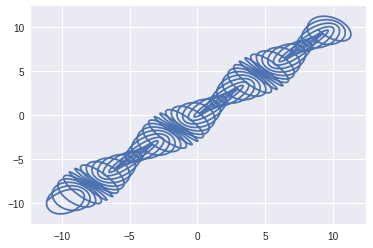

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

t = torch.linspace(-10, 10, steps = 10000)

# Посчитайте x(t), y(t)
x = t - 1.5*torch.cos(15*t)
y = t - 1.5*torch.sin(16*t)

plt.plot(x.numpy(), y.numpy())

## Automatic gradients

Всё это мог и numpy. А теперь переходим к тому, ради чего нужен PyTorch: backpropagation c помощью `Variable` и модуля `autograd`.

Начнём с простого примера с небольшим графом вычислений:

![graph](https://image.ibb.co/mWM0Lx/1_6o_Utr7_ENFHOK7_J4l_XJtw1g.png =500x)

In [6]:
x = autograd.Variable(torch.FloatTensor([-2]), requires_grad=True)
y = autograd.Variable(torch.FloatTensor([5]), requires_grad=True)
z = autograd.Variable(torch.FloatTensor([-4]), requires_grad=True)

q = x + y
f = q * z

f.backward()

In [7]:
print(x.grad)
print(y.grad)
print(z.grad)

Variable containing:
-4
[torch.FloatTensor of size 1]

Variable containing:
-4
[torch.FloatTensor of size 1]

Variable containing:
 3
[torch.FloatTensor of size 1]



__Нормальный пример:__ потренируем линейную регрессию на Boston Housing Dataset.

В целом, весь backpropagation выглядит как-то так:
1. У вас есть тензор. Он умеет в данные. Но вам не интересно просто в данные, хочется ещё и в градиенты.
2. Вы делаете ```a = autograd.Variable(data, requires_grad=True)```
3. Определяете функцию потерь `loss = whatever(a)`
4. Зовёте `loss.backward()`
5. ???
6. В ```a.grads``` записан нужный градиент.

Например:

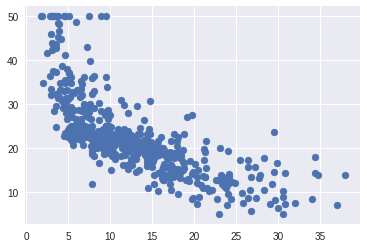

In [8]:
from sklearn.datasets import load_boston
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)

In [9]:
w = autograd.Variable(torch.zeros(1), requires_grad=True)
b = autograd.Variable(torch.zeros(1), requires_grad=True)

x = autograd.Variable(torch.FloatTensor(boston.data[:,-1] / 10))
y = autograd.Variable(torch.FloatTensor(boston.target))

In [10]:
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

# Пересчитываем градиенты
loss.backward()

Теперь в поле `.grad` есть градиенты.

In [11]:
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

dL/dw = 
 Variable containing:
-47.3514
[torch.FloatTensor of size 1]

dL/db = 
 Variable containing:
-45.0656
[torch.FloatTensor of size 1]



Если несколько раз посчитать лосс, градиенты каждый раз будут прибавляться. Поэтому важно занулять градиенты между итерациями.

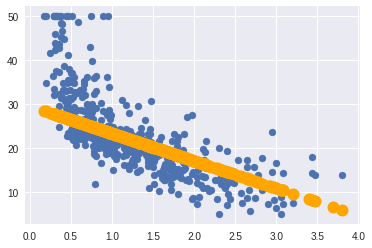

loss =  44.594173


In [12]:
from IPython.display import clear_output

for i in range(100):
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data
    
    # Зануляем градиенты
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if (i+1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy()[0])
        if loss.data.numpy()[0] < 0.5:
            print("Done!")
            break

### Cuda

Последняя особенность PyTorch - работа с cuda.

Вызовом `x = x.cuda()` мы перемещаем тензор на видеокарту. Точно так же перемещаются на видеокарту и все вычисления.

Кроме этого есть отдельный набор тензоров `torch.cuda.FloatTensor`, на случай, когда сразу понятно, что работаем на видеокарте.

Вернуться с видеокарты можно вызовом `.cpu()`.

---

А *путь джедая* только начинается. Прочитайте (всё ещё) статью [PyTorch — ваш новый фреймворк глубокого обучения](https://habrahabr.ru/post/334380/).

__Задание*__ Реализовать простую полносвязную сеть на чистом numpy. // todo

# Дорожка простых смертных

Начнём уже решать задачу - а с тем, что такое PyTorch, разберемся подробнее по ходу дела :)

Вспомним про датасет с прошлого занятия.

In [13]:
from keras.datasets import imdb

NUM_WORDS = 10000

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

NUM_LABELS = len(np.unique(y_train))
print(NUM_LABELS, 'class classification')

print('Converting to bag-of-word matrix...')
def convert_to_bow(X):
  X_bow = np.zeros((len(X), NUM_WORDS))
  for i, review in enumerate(X):
    for ind in review:
      X_bow[i, ind] = 1
  return X_bow

X_train_bow, X_test_bow = convert_to_bow(X_train), convert_to_bow(X_test)

y_train, y_test = y_train.reshape((-1, 1)), y_test.reshape((-1, 1))

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
2 class classification
Converting to bag-of-word matrix...


Мы тогда начали с BoW-модели. Повторим её на PyTorch!

*Напоминание*: на keras нам нужно было бы сделать следующее:
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train_bow, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test_bow, y_test))
```

Конечно же, в PyTorch можно сделать всё то же самое, но гораздо сложнее :)

## Определение модели
Начнём с определения модели:

In [28]:
model = nn.Sequential()

model.add_module('layer', nn.Linear(NUM_WORDS, 1))

model = model.cuda()

print(model)

Sequential(
  (layer): Linear(in_features=10000, out_features=1)
)


Пока всё просто, правда?

`Linear` вместо `Dense`, другие названия аргументов. И **нет** возможности задать функцию активации.

Ну, и добавился вызов `model.cuda()`

---

Дальше - сложнее.

Начнем с такой вот магии. О чём она - разберёмся чуть позже.

In [29]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield autograd.Variable(X[batch_idx, ]), autograd.Variable(Y[batch_idx, ])

X_train_bow, y_train = torch.cuda.FloatTensor(X_train_bow), torch.cuda.FloatTensor(y_train)
X_test_bow, y_test = torch.cuda.FloatTensor(X_test_bow), torch.cuda.FloatTensor(y_test)

Создадим свой собственный мини-батч:

In [16]:

X_batch, y_batch = next(get_batches((X_train_bow, y_train), 32))

Посмотрим на него глазами

In [17]:
X_batch, y_batch

(Variable containing:
     0     1     1  ...      0     0     0
     0     1     1  ...      0     0     0
     0     1     1  ...      0     0     0
        ...          ⋱          ...       
     0     1     1  ...      0     0     0
     0     1     1  ...      0     0     0
     0     1     1  ...      0     0     0
 [torch.cuda.FloatTensor of size 32x10000 (GPU 0)], Variable containing:
     1
     1
     0
     0
     1
     0
     1
     0
     0
     0
     1
     1
     0
     0
     0
     0
     1
     1
     0
     1
     0
     0
     0
     1
     1
     0
     0
     1
     1
     0
     0
     0
 [torch.cuda.FloatTensor of size 32x1 (GPU 0)])

Чтобы вычислить значение на этом батче, нужно позвать метод `forward`:

In [18]:
logit = model.forward(X_batch)

Смотрите, что он нам выдал:

In [19]:
logit

Variable containing:
 0.0209
 0.0130
 0.1299
-0.0946
 0.0955
 0.0238
-0.0799
-0.0513
 0.0235
 0.0249
 0.0320
-0.0795
-0.0319
-0.0369
 0.0055
 0.0477
 0.0003
-0.0089
-0.1121
 0.0430
 0.0046
-0.0023
-0.1348
 0.0219
-0.1117
 0.0229
-0.0183
 0.0872
-0.0168
 0.0136
-0.0900
-0.0739
[torch.cuda.FloatTensor of size 32x1 (GPU 0)]

В вероятности сконвертировать эти значения можно с помощью `F.sigmoid`

In [20]:
print(F.sigmoid(logit))
print(logit.sigmoid())

Variable containing:
 0.5052
 0.5032
 0.5324
 0.4764
 0.5239
 0.5059
 0.4800
 0.4872
 0.5059
 0.5062
 0.5080
 0.4801
 0.4920
 0.4908
 0.5014
 0.5119
 0.5001
 0.4978
 0.4720
 0.5107
 0.5011
 0.4994
 0.4663
 0.5055
 0.4721
 0.5057
 0.4954
 0.5218
 0.4958
 0.5034
 0.4775
 0.4815
[torch.cuda.FloatTensor of size 32x1 (GPU 0)]

Variable containing:
 0.5052
 0.5032
 0.5324
 0.4764
 0.5239
 0.5059
 0.4800
 0.4872
 0.5059
 0.5062
 0.5080
 0.4801
 0.4920
 0.4908
 0.5014
 0.5119
 0.5001
 0.4978
 0.4720
 0.5107
 0.5011
 0.4994
 0.4663
 0.5055
 0.4721
 0.5057
 0.4954
 0.5218
 0.4958
 0.5034
 0.4775
 0.4815
[torch.cuda.FloatTensor of size 32x1 (GPU 0)]



## Функция потерь
Нам бы теперь как-нибудь настроить параметры. А каким образом это работало в keras?

Посмотрите на ту строчку с `model.compile`. Ту часть, где мы задавали `loss`.

Что, собственно, она означает? Она говорит, что функция потерь имеет такой вид:
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot \log P(y_i | X_i) + (1-y_i) \cdot \log (1-P(y_i | X_i)) ]$$

А что предсказывает наша модель? Да просто какие-то значения. Если они большие - наверное, положительный класс. А если маленькие - отрицательный.

Можно было бы добавить в нашу модель ещё один слой:
```python
model.add_module('predictions_layer', nn.Sigmoid())
```
и тогда в ход пойдет `nn.BCELoss`, который делает ровно то, что написано в формуле сверху. 

А можно оставить всё как есть - но поставить `nn.BCEWithLogitsLoss`, который сам будет добавлять сигмоиду.

С помощью кого-то из них мы можем вычислять потери на нашем батче:


In [21]:
loss_function = nn.BCEWithLogitsLoss()

loss = loss_function(logit, y_batch)

Мы получили некоторое значение потерь:

In [22]:
loss

Variable containing:
 0.6879
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Но это не просто значение. У него есть `backward`!

In [23]:
loss.backward()

И мы можем получить градиент:

In [24]:
model.layer.weight.grad

Variable containing:
 0.0000  0.0912  0.0912  ...   0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 1x10000 (GPU 0)]


## Оптимизатор

Теперь мы можем настраивать параметры.

Например, с помощью SGD:
$$\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_\theta L(\theta)$$

Либо с помощью чего-то более сложного:

In [25]:
optimizer = optim.Adam(model.parameters())

print(model.layer.weight)

optimizer.step()

print(model.layer.weight)

Parameter containing:
1.00000e-03 *
 8.4254 -8.5424  9.5788  ...  -5.5823 -8.4498 -6.7656
[torch.cuda.FloatTensor of size 1x10000 (GPU 0)]

Parameter containing:
1.00000e-02 *
 0.8425 -0.9542  0.8579  ...  -0.5582 -0.8450 -0.6766
[torch.cuda.FloatTensor of size 1x10000 (GPU 0)]



Нужно вызывать `step()`, чтобы обновить параметры модели.

Последнее, но очень важное - **не забыть обнулить градиенты**. Делается это так:

In [26]:
optimizer.zero_grad()

## Цикл обучения

А теперь соберём всё вместе.

Напишем функцию-аналог `fit` в keras. 

Тут-то нам и понадобится `get_batches`. Keras, по доброте душевной, сам выделяет мини-батчи и вычисляет все потери, метрики (и не забывает обнулить градиенты).

In [32]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(10):
  train_epoch_loss = 0
  train_epochs_count = 0
  train_correct_count = 0
  for X_batch, y_batch in get_batches((X_train_bow, y_train), 128):
    # 1. Обнуляем градиенты
    optimizer.zero_grad()
    
    # 2. Запускаем forward-проход
    logits = model.forward(X_batch)
    
    # 3. Вычисляем потери
    loss = loss_function(logits, y_batch)
    
    # 4. Вычисляем градиенты на backward-проходе. А какие, собственно, градиенты он подсчитает?
    loss.backward()
    
    # 5. Оптимизируем параметры. Откуда он знает, какие параметры оптимизировать?
    optimizer.step()
    
    # Агрегируем лосс для вывода
    train_epoch_loss += loss.data.cpu()[0]
    train_epochs_count += 1
    
    # Вычисляем accuracy
    probs = F.sigmoid(logits)
    predictions = (probs > 0.5).type(torch.cuda.LongTensor)
    train_correct_count += np.sum((predictions == y_batch.type(torch.cuda.LongTensor)).cpu().data.numpy())
  
  val_epoch_loss = 0
  val_epochs_count = 0
  val_correct_count = 0
  # <your turn, calculate validation loss and accuracy>
  for X_batch, y_batch in get_batches((X_test_bow, y_test), 128):
    # 1. Запускаем forward-проход
    logits = model.forward(X_batch)
    
    # 2. Вычисляем потери
    loss = loss_function(logits, y_batch)
    
    # Агрегируем лосс для вывода
    val_epoch_loss += loss.data.cpu()[0]
    val_epochs_count += 1
    
    # Вычисляем accuracy
    probs = F.sigmoid(logits)
    predictions = (probs > 0.5).type(torch.cuda.LongTensor)
    val_correct_count += np.sum((predictions == y_batch.type(torch.cuda.LongTensor)).cpu().data.numpy())
  
  print('Train Loss = {:.5f}, Train Accuracy = {:.2%}, Val Loss = {:.5f}, Val Accuracy = {:.2%}'.format(
          train_epoch_loss / train_epochs_count, train_correct_count / len(y_train), 
          val_epoch_loss / val_epochs_count, val_correct_count / len(y_test)))

Train Loss = 0.35781, Train Accuracy = 88.70%, Val Loss = 0.35090, Val Accuracy = 87.89%
Train Loss = 0.29454, Train Accuracy = 90.54%, Val Loss = 0.31954, Val Accuracy = 88.54%
Train Loss = 0.26159, Train Accuracy = 91.60%, Val Loss = 0.30298, Val Accuracy = 88.86%
Train Loss = 0.23922, Train Accuracy = 92.29%, Val Loss = 0.29263, Val Accuracy = 88.92%
Train Loss = 0.22281, Train Accuracy = 92.79%, Val Loss = 0.28843, Val Accuracy = 88.96%
Train Loss = 0.20973, Train Accuracy = 93.24%, Val Loss = 0.28488, Val Accuracy = 88.91%
Train Loss = 0.19901, Train Accuracy = 93.67%, Val Loss = 0.28068, Val Accuracy = 88.94%
Train Loss = 0.18955, Train Accuracy = 93.93%, Val Loss = 0.27960, Val Accuracy = 89.00%
Train Loss = 0.18168, Train Accuracy = 94.28%, Val Loss = 0.27906, Val Accuracy = 88.94%
Train Loss = 0.17442, Train Accuracy = 94.57%, Val Loss = 0.28037, Val Accuracy = 88.81%


**Задание** Написать собственный оптимизатор (например, SGD) вместо Adam.

Параметры модели можно получить так:

In [33]:
for param in model.parameters():
  print(param)

Parameter containing:
-2.1250e-03  3.8119e-02 -3.0049e-02  ...  -1.1459e-02 -1.0548e-01  2.6337e-02
[torch.cuda.FloatTensor of size 1x10000 (GPU 0)]

Parameter containing:
1.00000e-02 *
  2.5414
[torch.cuda.FloatTensor of size 1 (GPU 0)]



У них есть `.grad`, который можно использовать для обновления параметров.

При этом занулять градиенты придется так: `model.zero_grad()`

In [37]:
class MyGD:
  def __init__(self, parameters):
    self.params = parameters
  def step(self):
    for param in self.params():
      param.data -= 0.01 * param.grad.data

      
loss_function = nn.BCEWithLogitsLoss()
optimizer = MyGD(model.parameters)

for epoch in range(10):
  train_epoch_loss = 0
  train_epochs_count = 0
  train_correct_count = 0
  for X_batch, y_batch in get_batches((X_train_bow, y_train), 128):
    # 1. Обнуляем градиенты
    model.zero_grad()
    
    # 2. Запускаем forward-проход
    logits = model.forward(X_batch)
    
    # 3. Вычисляем потери
    loss = loss_function(logits, y_batch)
    
    # 4. Вычисляем градиенты на backward-проходе. А какие, собственно, градиенты он подсчитает?
    loss.backward()
    
    # 5. Оптимизируем параметры. Откуда он знает, какие параметры оптимизировать?
    optimizer.step()
    
    # Агрегируем лосс для вывода
    train_epoch_loss += loss.data.cpu()[0]
    train_epochs_count += 1
    
    # Вычисляем accuracy
    probs = F.sigmoid(logits)
    predictions = (probs > 0.5).type(torch.cuda.LongTensor)
    train_correct_count += np.sum((predictions == y_batch.type(torch.cuda.LongTensor)).cpu().data.numpy())
  
  val_epoch_loss = 0
  val_epochs_count = 0
  val_correct_count = 0
  # <your turn, calculate validation loss and accuracy>
  for X_batch, y_batch in get_batches((X_test_bow, y_test), 128):
    # 1. Запускаем forward-проход
    logits = model.forward(X_batch)
    
    # 2. Вычисляем потери
    loss = loss_function(logits, y_batch)
    
    # Агрегируем лосс для вывода
    val_epoch_loss += loss.data.cpu()[0]
    val_epochs_count += 1
    
    # Вычисляем accuracy
    probs = F.sigmoid(logits)
    predictions = (probs > 0.5).type(torch.cuda.LongTensor)
    val_correct_count += np.sum((predictions == y_batch.type(torch.cuda.LongTensor)).cpu().data.numpy())
  
  print('Train Loss = {:.5f}, Train Accuracy = {:.2%}, Val Loss = {:.5f}, Val Accuracy = {:.2%}'.format(
          train_epoch_loss / train_epochs_count, train_correct_count / len(y_train), 
          val_epoch_loss / val_epochs_count, val_correct_count / len(y_test)))

Train Loss = 0.12101, Train Accuracy = 96.24%, Val Loss = 0.31137, Val Accuracy = 87.81%
Train Loss = 0.11860, Train Accuracy = 96.41%, Val Loss = 0.31300, Val Accuracy = 87.75%
Train Loss = 0.11826, Train Accuracy = 96.38%, Val Loss = 0.31169, Val Accuracy = 87.79%
Train Loss = 0.11879, Train Accuracy = 96.42%, Val Loss = 0.31207, Val Accuracy = 87.78%
Train Loss = 0.11827, Train Accuracy = 96.41%, Val Loss = 0.31193, Val Accuracy = 87.80%
Train Loss = 0.11837, Train Accuracy = 96.41%, Val Loss = 0.31077, Val Accuracy = 87.81%
Train Loss = 0.11821, Train Accuracy = 96.41%, Val Loss = 0.31120, Val Accuracy = 87.79%
Train Loss = 0.11801, Train Accuracy = 96.45%, Val Loss = 0.31140, Val Accuracy = 87.81%
Train Loss = 0.11800, Train Accuracy = 96.46%, Val Loss = 0.31142, Val Accuracy = 87.79%
Train Loss = 0.11801, Train Accuracy = 96.43%, Val Loss = 0.31205, Val Accuracy = 87.80%


## Module API

Кроме `Sequential` есть и более функциональный способ задавать модели:

In [38]:
class BoWClassifier(nn.Module):  # Наследуемся от nn.Module
    def __init__(self, num_labels, vocab_size):
        super().__init__()

        # Определяем слои, которые будем использовать
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, bow_vec):
        # Пропускаем вектор через них
        return self.linear(bow_vec)

# Word2Vec

Попробуем потренировать собственные эмбеддинги.

Сначала скачаем датасет (следующие четыре ячейки нужно просто запустить и надеяться, что в них всё правильно)

In [39]:
!wget -O text8.zip http://mattmahoney.net/dc/text8.zip
!unzip text8.zip

--2018-06-26 17:33:43--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  1.64MB/s    in 18s     

2018-06-26 17:34:02 (1.63 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
replace text8? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [40]:
with open('text8') as f:
  words = f.read().split()
print("data_size = {0}".format(len(words)))

data_size = 17005207


In [41]:
# Only N = 50000 the most frequent words is considered
# The other marked with token `UNK` (unknown)

from collections import Counter

def build_dataset(words, vocabulary_size):
  count = [[ "UNK", -1 ]]
  count.extend(Counter(words).most_common(vocabulary_size-1))
  print("Least frequent word: ", count[-1])
  word_to_index = { word: i for i, (word, _) in enumerate(count) }
  data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
  unk_count = data.count(0) # Number of unknown words
  count[0][1] = unk_count
  index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
  
  return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)

# Everything you need to know about the dataset

print("data: {0}".format(data[:10]))
print("count: {0}".format(count[:10]))
print("index_to_word: {0}".format(list(index_to_word.items())[:10]))

Least frequent word:  ('hif', 9)
data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [42]:
from collections import deque

def generate_batch(data_index, data_size, batch_size, bag_window):
  span = 2 * bag_window + 1 # [ bag_window, target, bag_window ]
  batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
  labels = np.ndarray(shape = (batch_size), dtype = np.int32)
  
  data_buffer = deque(maxlen = span)
  
  for _ in range(span):
    data_buffer.append(data[data_index])
    data_index = (data_index + 1) % data_size
    
  for i in range(batch_size):
    data_list = list(data_buffer)
    labels[i] = data_list.pop(bag_window)
    batch[i] = data_list
    
    data_buffer.append(data[data_index])
    data_index = (data_index + 1) % data_size
  return data_index, batch, labels


print("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
  data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
  print("bag_window = {0}".format(bag_window))
  print("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
  print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
bag_window = 1
batch = [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
labels = ['originated', 'as', 'a', 'term']

bag_window = 2
batch = [['first', 'used', 'early', 'working'], ['used', 'against', 'working', 'class'], ['against', 'early', 'class', 'radicals'], ['early', 'working', 'radicals', 'including']]
labels = ['against', 'early', 'working', 'class']



Напомню, мы тут собрались научиться получать эмбеддинги слов. Ну, и получать такие прикольные штуки, если повезёт:
![Word vectors relations](https://www.tensorflow.org/images/linear-relationships.png =700x)

Вообще говоря, каждое слово можно представлять и просто как индекс в словаре: 
$$\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}$$

Основной недостаток - размер таких векторов и отсутствие интерпретируемости. Хочется, чтобы было как-то так:
$$q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
\overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]$$
$$q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
\overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]$$

По таким векторам уже можно считать похожесть:
$$\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
{\| q_\text{physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)$$

Для тренировки таких представлений есть два наиболее популярных способа: skip-gram и CBoW.

## Continuous Bag of Words (CBoW)
В этой модели мы учимся предсказывать слово по его контексту:

![CBoW](http://evelinag.com/fsharpexchange2017/images/word2vec-cbow.png =500x)

Таким образом, учимся моделировать $P(w_c| w_{c-k}, \ldots, w_{c-1}, w_{c+1}, \ldots, w_{c+k})$.

При этом тренируются две матрицы. Собственно, матрица эмбеддингов $W_1$ и матрица выходного слоя $W_2$.

Вообще говоря, можно особо не думать и cчитать $softmax(W_2 q_c + b)$, где $q_c$ - сумма эмбеддингов слов из контекста, т.е. $q_c = \sum_{w_i \in c} W_1 w_i$. 

В результате получим некоторое распределение вероятностей на словаре, а нам нужно просто оптимизировать наши матрицы так, чтобы вероятность нужного слова была максимальной. 

Оптимизируется тут, как всегда, кросс-энтропия.

Разберемся чуть подробнее. Пусть $\tilde w_c$ -- это предсказываемое слово. $w_{c-k}, \ldots, w_{c-1}, w_{c+1}, \ldots, w_{c+k}$ - его контекст.

Сначала мы считаем эмбеддинги этих контекстных слов: $u_j = W_1 w_j, \ j = c-k, \ldots, c+k, \ j \neq c$.

Потом мы суммируем эти эмбеддинги: $u_c = \sum_j u_j$. Получили как бы эмбеддинг контекста.

А теперь вспоминаем про матрицу $W_2$. Она тоже содержит "эмбеддинги" векторов: $i$-тый столбец $v_i$ - эмбеддинг $i$-того слова.

Вот давайте учиться тому, чтобы эмбеддинг контекста был максимально похож на эмбеддинг слова:
$$-\log \frac{\exp(v_c^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)} \to \min.$$

Заметьте, мы считаем скалярное произведение между парой векторов, почти как в `Similarity` выше

*Ничего не понятно, да? :(*

In [123]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        # Просто эмбеддим все входные слова и суммируем полученные эмбеддинги = u_c
        embeds = self.embeddings(inputs).sum(dim=1)
        # Вычисляем W_2 x u_c = {v_i^T x u_c} из формулы выше
        out = self.out_layer(embeds)
        # Считаем log_softmax - логарифмы вероятностей того, что такое слово - центральное
        return F.log_softmax(out, dim=1)
      
# Строим эмбеддинги размерности 50
model = CBOW(vocabulary_size, 50)
model = model.cuda()

# NLLLoss - кросс-энтропийная функция потерь для логарифмов вероятностей
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  

In [44]:
data_index, data_size, batch_size, bag_window = 0, len(data), 64, 2
  
loss_every_nsteps = 1000
total_loss = 0
for step in range(50000):
    data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    batch, labels = autograd.Variable(torch.cuda.LongTensor(batch)), autograd.Variable(torch.cuda.LongTensor(labels))

    optimizer.zero_grad()

    log_probs = model(batch)

    loss = loss_function(log_probs, labels)
    loss.backward()

    optimizer.step()

    total_loss += loss.data
    if step % loss_every_nsteps == 0:
        if step > 0:
            total_loss /= loss_every_nsteps
            display.clear_output(True)
            print("step = {0}, average_loss = {1}".format(step, total_loss.cpu().numpy()[0]))
            total_loss = 0

step = 49000, average_loss = 7.675750732421875


Визуализировать всё это можно так:

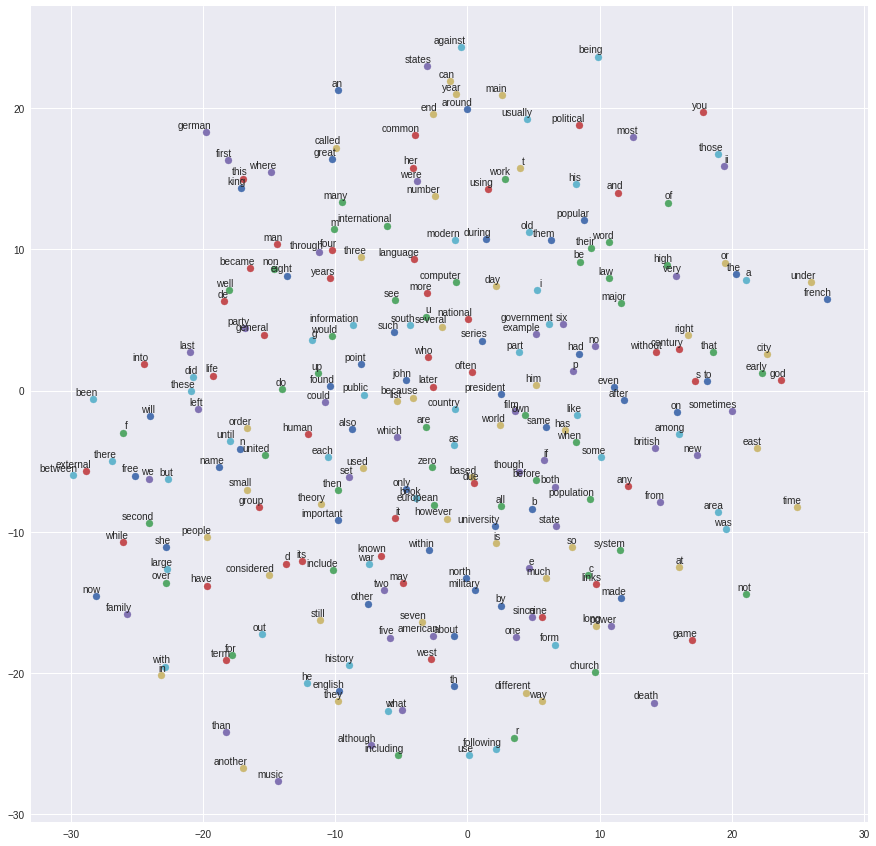

In [45]:
from sklearn.manifold import TSNE

num_points = 250

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(model.embeddings.weight.data.cpu().numpy()[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

## Negative Sampling
Вообще говоря, считать softmax на большом словаре - очень долго и вычислительно сложно.

Один из способов справиться с этим - использовать *Negative Sampling*.

По сути, вместо предсказания индекса слова по контексту предсказывается вероятность того, что такое слово может быть в таком контексте: $P(D=1|w,c)$.

Можно использовать обычную сигмоиду для получения данной вероятности: 
$$P(D=1|w, c) = \sigma(v_w^T u_c) = \frac 1 {1 + \exp(-v^T_w u_c)}.$$

Процесс обучения тогда выглядит так: для каждой пары слово и его контекст генерируем набор отрицательных примеров:

![Negative Sampling](https://image.ibb.co/dnOUDH/Negative_Sampling.png =350x)

Для CBoW функция потерь будет выглядеть так:
$$-\log \sigma(v_c^T u_c) - \sum_{k=1}^K \log \sigma(-\tilde v_k^T u_c),$$
где $\tilde v_1, \ldots, \tilde v_K$ - сэмплированные негативные примеры.

Сравните эту формулу с обычным CBoW:
$$-v_c^T u_c + \log \sum_{i=1}^{|V|} \exp(v_i^T u_c).$$

Обычно слова сэмплируются из $U^{3/4}$, где $U$ - униграмное распределение, т.е частоты появления слова делённые на суммарое число слов. 

Частотности мы уже считали: они получаются в `Counter(words)`. Достаточно просто преобразовать их в вероятности и домножить эти вероятности на $\frac 3 4$. Почему $\frac 3 4$? Некоторую интуицию можно найти в следующем примере:

$$P(\text{is}) = 0.9, \ P(\text{is})^{3/4} = 0.92$$
$$P(\text{Constitution}) = 0.09, \ P(\text{Constitution})^{3/4} = 0.16$$
$$P(\text{bombastic}) = 0.01, \ P(\text{bombastic})^{3/4} = 0.032$$

Вероятность для высокочастотных слов особо не увеличилась (относительно), зато низкочастотные будут выпадать с заметно большей вероятностей.

**Задание** Реализуйте свой Negative Sampling.

In [69]:
print(type(count))
print(count[:10])
U = [x[1] for x in count]
S = sum(U)
U = [x/S for x in U]
print(U[:10])
U = torch.autograd.Variable(torch.FloatTensor(U))

<class 'list'>
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
[0.024603699325741815, 0.06241594118789615, 0.034911483288618594, 0.02450008400368193, 0.02421399516042351, 0.021887472466521576, 0.019163130445868728, 0.018604654444959123, 0.015581992033381306, 0.014726665779487424]


In [109]:
class NegativeSamplingCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, inputs, targets, num_samples):
        '''
        inputs : (batch_size, context_size)
        targets: (batch_size)
        '''
        # Находим u_c
        embeds = self.embeddings(inputs).sum(dim=1)
        # Считаем v_c
        outputs = self.out_embeddings(targets)
        
        [batch_size, context_size] = inputs.size()
        # <Sample indices for v_1, ..., v_K>
        samples = torch.multinomial(U, batch_size*num_samples, True).view(batch_size, num_samples)
        samples = samples.cuda()

        # print(samples.size())
        # print(inputs.size())
        # print(targets.size())
        # <Calculate v_1, ..., v_K using self.out_embeddings>
        noise = self.out_embeddings(samples).neg()
        
        log_center = (embeds * outputs).sum(1).squeeze().sigmoid().log()
        sum_log_sampled = torch.bmm(noise, embeds.unsqueeze(2)).sigmoid().log().sum(1).squeeze()
        
        loss = log_center + sum_log_sampled
        
        return -loss.sum() / batch_size
        
# Строим эмбеддинги размерности 50
model = NegativeSamplingCBOW(vocabulary_size, 50)
model = model.cuda()

# Обратите внимание, loss уже не нужен!
# Считаем его прямо в классе
# Таким образом, просто делаем loss = model(batch)
optimizer = optim.SGD(model.parameters(), lr=0.01)  

In [113]:
data_index, data_size, batch_size, bag_window = 0, len(data), 64, 2
neg_samples = 50
  
loss_every_nsteps = 1000
total_loss = 0
for step in range(10000):
    data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    batch, labels = autograd.Variable(torch.cuda.LongTensor(batch)), autograd.Variable(torch.cuda.LongTensor(labels))

    optimizer.zero_grad()

    loss = model(batch, labels, neg_samples)


    loss.backward()

    optimizer.step()

    total_loss += loss.data
    if step % loss_every_nsteps == 0:
        if step > 0:
            total_loss /= loss_every_nsteps
            display.clear_output(True)
            print("step = {0}, average_loss = {1}".format(step, total_loss.cpu().numpy()[0]))
            total_loss = 0

step = 9000, average_loss = 33.75487518310547


## Skip-Gram

В Skip-gram модели всё наоборот. Предсказываются слова из контекста по данному слову.

![Skip-gram](https://adriancolyer.files.wordpress.com/2016/04/word2vec-skip-gram.png?w=600)

Теперь учимся моделировать вероятность $P(w_{c-k}, \ldots, w_{c-1}, w_{c+1}, \ldots, w_{c+k} | w_c)$. Это, конечно, сложно, поэтому упростим всё - используем наивного Байеса:
$P(w_{c-k}, \ldots, w_{c-1}, w_{c+1}, \ldots, w_{c+k} | w_c) = \prod_{j=-k, j \neq 0}^k P(w_{c+j} | w_c)$. Посмотрите ещё раз на картинку - там наприсовано именно это (точнее, там нарисовано, что тренируется всего одна матрица $W_2$).

Оптимизировать нужно всё ту же кросс-энтропию. Только теперь уже нужно суммировать кросс-энтропийные потери для всех слов в контексте.

**Задание** Реализовать, ага.

Начнем с генерации батча. Представить, что там происходит, проще всего по этой картинке:
![skip-gram-batch](https://raw.githubusercontent.com/deepmipt/deep-nlp-seminars/44f574efe79ca1613d77336e4163061f9d5566c6/seminar_02/pics/training_data.png =600x)

Т.е. тренировочные данные состоят из пар (слово, слово из контекста).

В результате, если вся выборка будет состоять из одного этого предложения, распределение вероятностей, которое мы стремимся получить, для слова `brown` будет таким:

![skip-gram-illustration](https://image.ibb.co/eJ3otH/SkipGram.png =600x)

Каждое из слов в его контексте получает одинаковую вероятность $1 \over 4$, а все остальные слова - ноль. 

In [46]:
import random

def generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print("data = {0}\n".format([index_to_word[each] for each in data[:32]]))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch_2(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print("batch = {0}".format([index_to_word[each] for each in batch]))
    print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

data_index = 11, num_skips = 2, skip_window = 1
batch = ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
labels = ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of', 'abuse', 'term', 'of', 'first', 'abuse', 'used', 'against', 'first']

data_index = 9, num_skips = 4, skip_window = 2
batch = ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
labels = ['term', 'anarchism', 'a', 'originated', 'of', 'as', 'originated', 'term', 'as', 'of', 'abuse', 'a', 'abuse', 'first', 'term', 'a']



In [127]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = self.out_layer(embeds)
        return F.log_softmax(out, dim=1)     

In [128]:
# Строим эмбеддинги размерности 50
model = SkipGram(vocabulary_size, 50)
model = model.cuda()

# NLLLoss - кросс-энтропийная функция потерь для логарифмов вероятностей
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  

In [131]:
data_index, data_size, batch_size, num_skips, skip_window = 0, len(data), 64, 4, 2
  
loss_every_nsteps = 1000
total_loss = 0
for step in range(50000):
    data_index, batch, labels = generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window)
    batch, labels = autograd.Variable(torch.cuda.LongTensor(batch)), autograd.Variable(torch.cuda.LongTensor(labels))

    optimizer.zero_grad()

    log_probs = model(batch)

    loss = loss_function(log_probs, labels.squeeze())
    loss.backward()

    optimizer.step()

    total_loss += loss.data
    if step % loss_every_nsteps == 0:
        if step > 0:
            total_loss /= loss_every_nsteps
            display.clear_output(True)
            print("step = {0}, average_loss = {1}".format(step, total_loss.cpu().numpy()[0]))
            total_loss = 0

step = 49000, average_loss = 8.030526161193848
